Transformer

[Master Positional Encoding](https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3)  
[Transformer Architecture: The Positional Encoding](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)  
[Multi-head attention mechanism](https://data-science-blog.com/blog/2021/04/07/multi-head-attention-mechanism/)  
[The Illustrated Transformer](https://nlpinkorean.github.io/illustrated-transformer/)  
[Code Reference](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Attention_is_All_You_Need_Tutorial_(German_English).ipynb)

<img src = 'img/transformer.png' />

In [249]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Positional Embedding

Input에 Sequential한 위치정보를 반영시키기 위해 Positional encoding을 더하여 Encoder에 입력하게 된다. 이 Embedding은 학습 파라미터로 설정해도 되지만 논문에서는 다음과 같은 positional encoding을 사용한다.

$$
\begin{gathered}
\mathrm{PE}_{(p o s, 2 i)}=\sin \left(p o s / 10000^{2 i / d_{\text {model }}}\right) \\
\mathrm{PE}_{(p o s, 2 i+1)}=\cos \left(p o s / 10000^{2 i / d_{\text {model }}}\right)
\end{gathered}
$$

이러한 encoding을 사용한 이유는 고정된 offset $k$에 대해서 $\mathrm{PE}_{pos+k} = \mathrm{PE}_{pos} \mathbf{T}^{(k)}$ 인 선형변환 $\mathbf{T}^{(k)}$가 존재하기 때문이다.

In [98]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, max_len=200):
        super(PositionalEncoding, self).__init__()
        
        positional_encoding = torch.empty(max_len, d_hid, dtype=torch.float32)
        position = torch.arange(max_len, dtype=torch.float32).unsqueeze(1)
        index = torch.pow(1e-4, torch.arange(0, d_hid, 2, dtype=torch.float32)/d_hid)
        positional_encoding[:,::2] = torch.sin(position*index)
        positional_encoding[:,1::2] = torch.cos(position*index)
        
        self.scale = np.sqrt(d_hid)
        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, x):
        return x*self.scale + self.positional_encoding[:x.size(-2)]

Position별 더해지는 positional encoding은 다음과 같다.

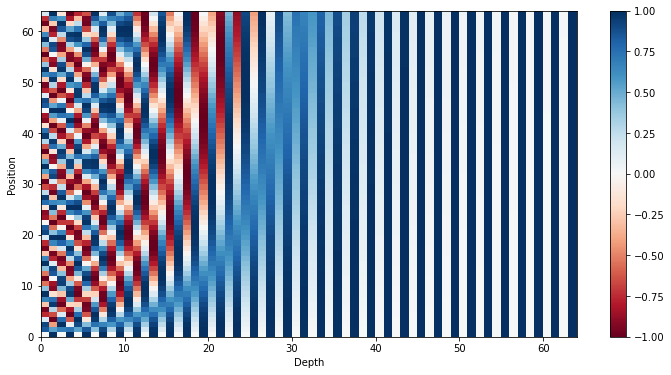

In [111]:
pe = PositionalEncoding(d_hid=64, max_len=64)

plt.figure(figsize=(12,6))
plt.pcolormesh(pe.positional_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

두 개의 position embedding에 대해서 서로의 내적값을 보면 다음과 같다. 두 벡터가 가까울수록 값이 높아지고, 떨어져있을수록 값이 낮아지므로 두 단어에 대한 상대적 위치정보를 모델이 잘 학습 할것이라 기대할 수 있다.

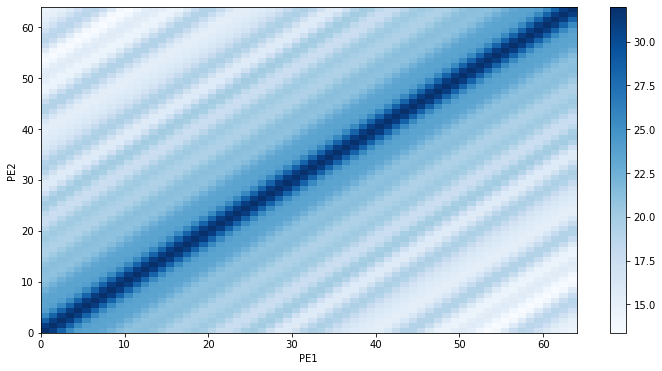

In [112]:
plt.figure(figsize=(12,6))
plt.pcolormesh(pe.positional_encoding.matmul(pe.positional_encoding.t()), cmap='Blues')
plt.xlabel('PE1')
plt.ylabel('PE2')
plt.colorbar()
plt.show()

## Ⅱ. Scaled Dot-Product Attention

<img src='img/scaled_dot_product_attention.png' width=75% />

Query $\mathbf{Q}$ 와 Key $\mathbf{K}$의 유사도를 dot-product를 통해 계산하고 이를 scale factor $\sqrt{d_hid}$ 로 나누어 준다. scale factor $\sqrt{d_hid}$는 d_hid에 무관하게 dot-product값들이 분포되게 하여 gradient가 더 안정적이게 흐르게 해준다. 이후 attention에 무관한 값들은 mask를 씌운다음 softmax를 통해 weight를 얻는다. 구한 weight에 따라 Value $\mathbf{V}$의 weighted sum을 출력한다.

$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}, \text{mask}) = \text{softmax}\left( \frac{\mathbf{QK}^T}{\sqrt{d_k}} \odot \text{mask} \right) \mathbf{V}
$$

In [251]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, temperature, dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V, mask=None):

        energy = torch.matmul(Q, K.transpose(-1, -2)) / self.temperature

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e9)

        attention = self.dropout(F.softmax(energy, dim=-1))
        output = torch.matmul(attention, V)

        return output, attention

In [258]:
batch_size = 32
n_head = 8
seq_length = 50
d_k = 16

sdpa = ScaledDotProductAttention(np.sqrt(d_k))
Q = torch.Tensor(batch_size, n_head, seq_length, d_k)
K = torch.Tensor(batch_size, n_head, seq_length, d_k)
V = torch.Tensor(batch_size, n_head, seq_length, d_k)
out, attention = sdpa(Q, K, V)

print('Input Shape')
print('  Query :', Q.shape)
print('  Key :', K.shape)
print('  Value :', V.shape)

print('Output Shape')
print('  Output :', out.shape)
print('  Attention :', attention.shape)

Input Shape
  Query : torch.Size([32, 8, 50, 16])
  Key : torch.Size([32, 8, 50, 16])
  Value : torch.Size([32, 8, 50, 16])
Output Shape
  Output : torch.Size([32, 8, 50, 16])
  Attention : torch.Size([32, 8, 50, 50])


Mask는 소스 문장의 경우 padding 토큰이 아닌 단어들만 참조할 수 있도록, 타겟 문장의 경우 이전 단어들만 참조할 수 있도록 mask를 씌운다. 이를 시각화하면 다음과 같다.

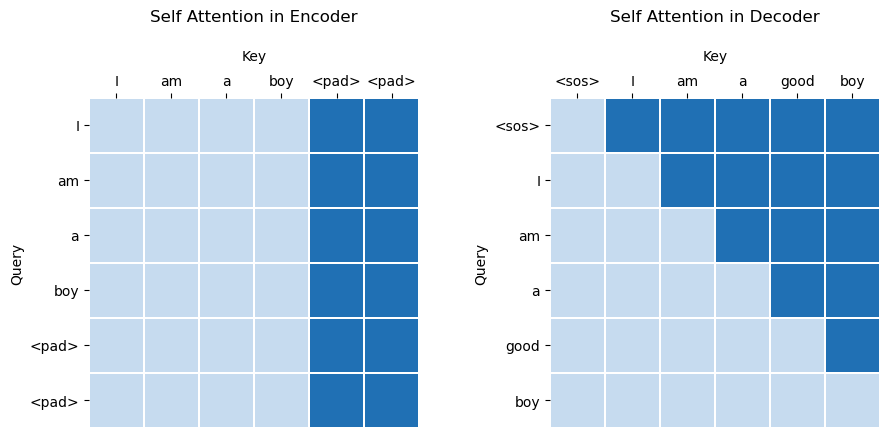

In [238]:
query1 = np.array(['I', 'am', 'a', 'boy', '<pad>', '<pad>'])
mask1 = np.tile(query1 == '<pad>', (len(query1), 1))

query2 = np.array(['<sos>', 'I', 'am', 'a', 'good', 'boy'])
mask2 = np.triu(np.ones((len(query2), len(query2))), k=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), dpi=100)

sns.heatmap(mask1, ax=ax1, xticklabels=query1, yticklabels=query1, square=True, 
            linewidth=0.8 , cmap='Blues', cbar=False, vmin=-0.5, vmax=1.5)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.tick_params(axis='y', labelrotation=0)
ax1.set_title('Self Attention in Encoder', pad=20)
ax1.set_xlabel('Key', labelpad=10)
ax1.set_ylabel('Query')

sns.heatmap(mask2, ax=ax2, xticklabels=query2, yticklabels=query2, square=True, 
            linewidth=0.8 , cmap='Blues', cbar=False, vmin=-0.5, vmax=1.5)
ax2.tick_params(axis='y', labelrotation=0)
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.set_title('Self Attention in Decoder', pad=20)
ax2.set_xlabel('Key', labelpad=10)
ax2.set_ylabel('Query')

plt.tight_layout(w_pad=4.0)
plt.show()

## Ⅲ. Multihead Attention

<img src='img/multihead_attention.png' width=50% />

In [259]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn